# Walkthrough for using the Fast Stylometry model for Burrows' Delta

By [Thomas Wood](https://freelancedatascientist.net), [Fast Data Science](https://fastdatascience.com)

Burrows' Delta is an algorithm for comparing the similarity of the writing styles of documents, known as [forensic stylometry](https://fastdatascience.com/how-you-can-identify-the-author-of-a-document/).

* [A useful explanation of the maths and thinking behind Burrows' Delta and how it works](https://programminghistorian.org/en/lessons/introduction-to-stylometry-with-python#third-stylometric-test-john-burrows-delta-method-advanced)

Demonstration of Burrows' Delta on a small corpus downloaded from Project Gutenberg.

We will test the Burrows' Delta code on two "unknown" texts: Sense and Sensibility by Jane Austen, and Villette by Charlotte Bronte. Both authors are in our training corpus.

This notebook demonstrates how to use the library to calculate the Burrows' Delta value of six candidate authors, and also to calculate the probability that each one is the author of the mystery text.

In [1]:
from faststylometry.util import load_corpus_from_folder
from faststylometry.en import tokenise_remove_pronouns_en
from faststylometry.burrows_delta import calculate_burrows_delta
from faststylometry.corpus import Corpus
from faststylometry.probability import predict_proba, calibrate

In [2]:
train_corpus = load_corpus_from_folder("faststylometry/data/train")

train_corpus.tokenise(tokenise_remove_pronouns_en)

#split_train_corpus = train_corpus.split(10000)

# Load two books by "unknown" authors to test the algorithm

In [3]:
# Load Sense and Sensibility, written by Jane Austen

test_corpus_sense_and_sensibility = load_corpus_from_folder("faststylometry/data/test", pattern="sense")

test_corpus_sense_and_sensibility.tokenise(tokenise_remove_pronouns_en)



In [4]:
# Load Villette, written by Charlotte Bronte

test_corpus_villette = load_corpus_from_folder("faststylometry/data/test", pattern="villette")

test_corpus_villette.tokenise(tokenise_remove_pronouns_en)


# Calculate Burrows' Delta for both candidate authors

In [5]:
calculate_burrows_delta(train_corpus, test_corpus_sense_and_sensibility)

,delta
author,
austen,0.459225
bronte,0.943223
carroll,1.342882
conan_doyle,1.046263
dickens,1.138193
swift,1.546629


In [6]:
calculate_burrows_delta(train_corpus, test_corpus_villette)

,delta
author,
austen,1.019522
bronte,0.455403
carroll,1.045689
conan_doyle,0.820858
dickens,0.712425
swift,1.438522


# Calibrate the model and calculate the probability of each candidate in the training set being the author

In [7]:
calibrate(train_corpus)

In [8]:
predict_proba(train_corpus, test_corpus_sense_and_sensibility)

,proba
author,
austen,0.765904
bronte,0.476708
carroll,0.240672
conan_doyle,0.409646
dickens,0.352453
swift,0.156141


In [9]:
predict_proba(train_corpus, test_corpus_villette)

,proba
author,
austen,0.426832
bronte,0.767709
carroll,0.410013
conan_doyle,0.557251
dickens,0.626319
swift,0.197555


# Plot the calibration curve

We have used Scikit Learn's Logistic Regression to calculate the calibration curve of the model. You could also use your own calibration curve.

In [10]:
import numpy as np
x_values =  np.arange(0, 3, 0.1)

import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Calibration curve of the Burrows Delta probability model\nUsing Logistic Regression with correction for class imbalance')

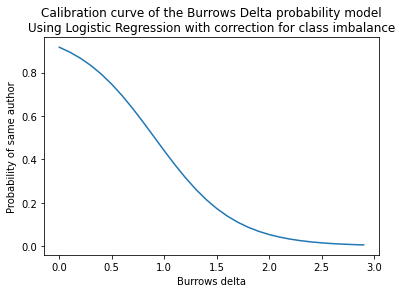

In [11]:
plt.plot(x_values, train_corpus.probability_model.predict_proba(np.reshape(x_values, (-1, 1)))[:,1])
plt.xlabel("Burrows delta")
plt.ylabel("Probability of same author")
plt.title("Calibration curve of the Burrows Delta probability model\nUsing Logistic Regression with correction for class imbalance")